# 1. Environment Setup

Imported essential Python libraries for data cleaning, numerical analysis, and visualizing price–demand relationships in the retail dataset.

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

plt.style.use('default')
sns.set()


# 2. Load & Inspect Data

Loaded the retail scanner dataset and performed an initial inspection to understand column structure, data types, and basic statistical patterns before analysis.

In [80]:
df = pd.read_csv(r"C:\Users\sande\OneDrive\Desktop\projetcs\Price-Demand-Sensitivity-Analysis\scanner_data.csv")


In [81]:
df.head()


,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [82]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      131706 non-null  int64  
 1   Date            131706 non-null  object 
 2   Customer_ID     131706 non-null  int64  
 3   Transaction_ID  131706 non-null  int64  
 4   SKU_Category    131706 non-null  object 
 5   SKU             131706 non-null  object 
 6   Quantity        131706 non-null  float64
 7   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 8.0+ MB


In [83]:
df.describe()

,Unnamed: 0,Customer_ID,Transaction_ID,Quantity,Sales_Amount
count,131706.000000,131706.000000,131706.000000,131706.000000,131706.000000
mean,65853.500000,12386.450367,32389.604187,1.485311,11.981524
std,38020.391614,6086.447552,18709.901238,3.872667,19.359699
min,1.000000,1.000000,1.000000,0.010000,0.020000
25%,32927.250000,7349.000000,16134.000000,1.000000,4.230000
50%,65853.500000,13496.000000,32620.000000,1.000000,6.920000
75%,98779.750000,17306.000000,48548.000000,1.000000,12.330000
max,131706.000000,22625.000000,64682.000000,400.000000,707.730000


# 3. Data Cleaning

Prepared the dataset by fixing column names, converting dates, removing invalid quantity records, and computing unit prices. Basic outliers were filtered to ensure reliable price–demand analysis.

1. Flexible column detection function

In [84]:
def find_col(df, candidates):
    cols = df.columns.tolist()
    low_map = {c.lower(): c for c in cols}
    for cand in candidates:
        candl = cand.lower()
        for col_low, col_orig in low_map.items():
            if candl in col_low:
                return col_orig
    return None

2. Detect important columns

In [85]:
date_col  = find_col(df, ["date", "sales date", "transaction date"])
qty_col   = find_col(df, ["quantity", "qty", "units", "sold"])
sales_col = find_col(df, ["sales_amount", "sales", "revenue", "amount"])
price_col = find_col(df, ["price", "unit_price", "selling_price"])

print("Detected columns:")
print(" date_col  :", date_col)
print(" qty_col   :", qty_col)
print(" sales_col :", sales_col)
print(" price_col :", price_col)

Detected columns:
 date_col  : Date
 qty_col   : Quantity
 sales_col : Sales_Amount
 price_col : None


3. Rename columns to standard names

In [86]:
working = df.copy()

if date_col:  working = working.rename(columns={date_col: "date"})
if qty_col:   working = working.rename(columns={qty_col: "quantity"})
if sales_col: working = working.rename(columns={sales_col: "sales"})
if price_col: working = working.rename(columns={price_col: "price"})

print("\nColumns after renaming:")
print(working.columns.tolist())


Columns after renaming:
['Unnamed: 0', 'date', 'Customer_ID', 'Transaction_ID', 'SKU_Category', 'SKU', 'quantity', 'sales']


4. Parse data types

In [87]:
if "date" in working.columns:
    working["date"] = pd.to_datetime(working["date"], errors="coerce")

5. Convert numeric columns

In [88]:
if "quantity" in working.columns:
    working["quantity"] = pd.to_numeric(working["quantity"], errors="coerce")
if "sales" in working.columns:
    working["sales"] = pd.to_numeric(working["sales"], errors="coerce")
if "price" in working.columns:
    working["price"] = pd.to_numeric(working["price"], errors="coerce")


5. Compute missing price or sales

- If price missing → compute price = sales / quantity

In [89]:
if ("price" not in working.columns) or working["price"].isna().all():
    if ("sales" in working.columns) and ("quantity" in working.columns):
        with np.errstate(divide='ignore', invalid='ignore'):
            working["price"] = working["sales"] / working["quantity"]
        print("\nComputed price using: price = sales / quantity")
    else:
        print("\nCannot compute price (missing sales or quantity).")


Computed price using: price = sales / quantity


- If sales missing → compute sales = price * quantity

In [90]:
if ("sales" not in working.columns) or working["sales"].isna().all():
    if ("price" in working.columns) and ("quantity" in working.columns):
        working["sales"] = working["price"] * working["quantity"]
        print("\nComputed sales using: sales = price * quantity")
    else:
        print("\nCannot compute sales (missing price or quantity).")

6. Remove invalid rows

In [91]:
before = working.shape[0]
working = working.dropna(subset=["price", "quantity"])
working = working[(working["price"] > 0) & (working["quantity"] > 0)]
after = working.shape[0]

print(f"\nDropped {before - after} invalid rows (missing or non-positive price/quantity).")
print("Remaining rows:", after)


Dropped 0 invalid rows (missing or non-positive price/quantity).
Remaining rows: 131706


7. Create revenue column

In [92]:
working["revenue"] = working["price"] * working["quantity"]

print("\nData cleaning complete.")
display(working.head())


Data cleaning complete.


,Unnamed: 0,date,Customer_ID,Transaction_ID,SKU_Category,SKU,quantity,sales,price,revenue
0,1,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,3.13,3.13
1,2,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,5.46,5.46
2,3,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,6.35,6.35
3,4,2016-02-01,3719,4,0H2,549KK,1.0,5.59,5.59,5.59
4,5,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,6.88,6.88


# 4. Exploratory Data Analysis (EDA)

1. Basic summary

Provides key statistics (mean, median, std, min, max) for price, quantity, sales, and revenue. Helps understand overall data shape before deeper analysis.

In [93]:
print("Summary Statistics:")
display(working[["price", "quantity", "sales", "revenue"]].describe())

Summary Statistics:


,price,quantity,sales,revenue
count,131706.000000,131706.000000,131706.000000,131706.000000
mean,9.692429,1.485311,11.981524,11.981524
std,14.944890,3.872667,19.359699,19.359699
min,0.015000,0.010000,0.020000,0.020000
25%,3.680000,1.000000,4.230000,4.230000
50%,6.070000,1.000000,6.920000,6.920000
75%,10.100000,1.000000,12.330000,12.330000
max,693.800000,400.000000,707.730000,707.730000


- Check if price or quantity has extreme values (outliers).
- High standard deviation means wide variation good for elasticity analysis.
- Compare mean vs median to detect skewness.

2. Price Distribution

Histogram showing how product prices are distributed across the dataset.

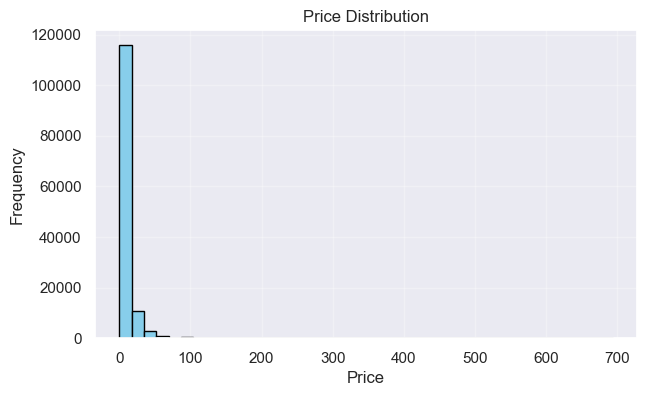

In [94]:
plt.figure(figsize=(7,4))
plt.hist(working['price'], bins=40, color='skyblue', edgecolor='black')
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

- If most prices cluster at a specific range → less freedom to adjust pricing.
- Wide spread = better natural experiments for elasticity.
- If there are extremely high-price outliers, consider filtering them.

3. Quantity Distribution

Shows how many units are typically sold per SKU/transaction.

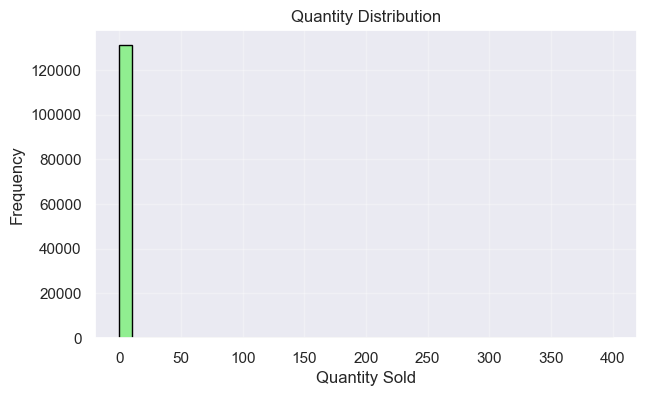

In [95]:
plt.figure(figsize=(7,4))
plt.hist(working['quantity'], bins=40, color='lightgreen', edgecolor='black')
plt.title("Quantity Distribution")
plt.xlabel("Quantity Sold")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

- Most retail datasets show right-skewed distribution (many low quantities).
- Helps identify bulk-sold products vs single-unit products.
- Outliers may indicate promotions or big orders.

4. Demand Curve (Price vs Quantity)

Scatter plot that illustrates the relationship between price and quantity — the visual demand curve.

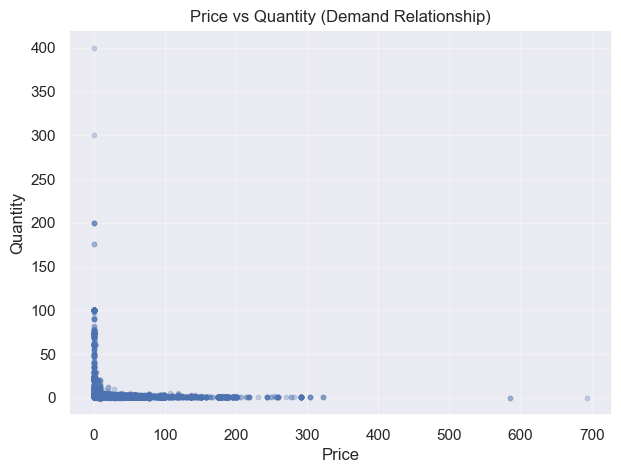

In [96]:
plt.figure(figsize=(7,5))
plt.scatter(working['price'], working['quantity'], alpha=0.25, s=10)
plt.title("Price vs Quantity (Demand Relationship)")
plt.xlabel("Price")
plt.ylabel("Quantity")
plt.grid(alpha=0.3)
plt.show()

- Should generally slope downward → law of demand. 
- If the scatter is very noisy → market influenced by promotions, bundles, or seasonality.
- A clear downward trend indicates predictable consumer behavior.

5. Price vs Revenue (Revenue Curve)

Graph showing how revenue changes with price. Reveals where revenue peaks.

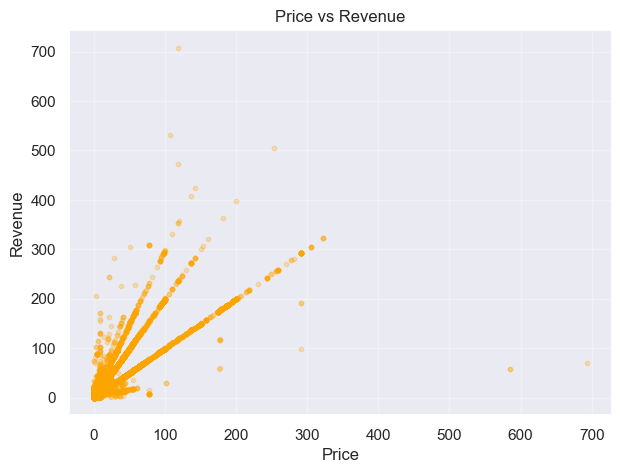

In [97]:
plt.figure(figsize=(7,5))
plt.scatter(working['price'], working['revenue'], alpha=0.25, s=10, color='orange')
plt.title("Price vs Revenue")
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.grid(alpha=0.3)
plt.show()

- Revenue rises with price initially but eventually falls when quantity drops → unit elasticity point.
- The peak region = best price range for maximizing revenue.
- If revenue keeps rising with price → demand may be inelastic.

This EDA establishes the basic economic structure of the dataset showing how price interacts with quantity and revenue. It confirms whether the dataset supports meaningful elasticity estimation and reveals category-level pricing dynamics.

# 5 .Price Elasticity of Demand

Price Elasticity of Demand (PED) measures how strongly quantity demanded changes when price changes.

Why It’s Important:- 

- Helps decide the best price to increase sales or revenue
- Shows whether customers are price-sensitive or price-insensitive
- Identifies the revenue-maximizing price
- Reveals consumer behavior and market competitiveness

What Insights we'll Get :- 

- Whether demand is elastic, inelastic, or unit elastic
- How price affects quantity and revenue
- The optimal price range for maximum revenue
- Category-level pricing behavior
- A statistically accurate elasticity estimate using regression

1. Point Elasticity (Percent Change Method)

Compares percent change in quantity to percent change in price between consecutive price points.
Gives a rough, local elasticity measure.

In [98]:

elastic_df = working.sort_values("price").reset_index(drop=True)

elastic_df["pct_p"] = elastic_df["price"].pct_change()
elastic_df["pct_q"] = elastic_df["quantity"].pct_change()

elastic_df["elasticity_point"] = elastic_df["pct_q"] / elastic_df["pct_p"]

display(elastic_df[["price", "quantity", "pct_p", "pct_q", "elasticity_point"]].head(12))


,price,quantity,pct_p,pct_q,elasticity_point
0,0.015,2.0,NaN,NaN,NaN
1,0.015,2.0,0.000000,0.0,NaN
2,0.015,2.0,0.000000,0.0,NaN
3,0.015,2.0,0.000000,0.0,NaN
4,0.015,2.0,0.000000,0.0,NaN
5,0.020,1.0,0.333333,-0.5,-1.5
6,0.020,1.0,0.000000,0.0,NaN
7,0.020,1.0,0.000000,0.0,NaN
8,0.020,1.0,0.000000,0.0,NaN
9,0.020,1.0,0.000000,0.0,NaN


- Elasticity < –1 → Elastic (customers are price-sensitive)
- Between 0 and –1 → Inelastic
- = –1 → Unit elastic (revenue-maximizing zone)

This gives a quick, raw idea of how quantity reacts to price changes.

2. Elasticity Using Log-Log Regression 

- Uses statistical regression:

ln(Q)=a+bln(P)

- The coefficient b = elasticity.
- This is the standard economics method.

In [99]:

reg_df = working[(working["price"] > 0) & (working["quantity"] > 0)].copy()

reg_df["log_P"] = np.log(reg_df["price"])
reg_df["log_Q"] = np.log(reg_df["quantity"])

X = sm.add_constant(reg_df["log_P"])
model = sm.OLS(reg_df["log_Q"], X).fit()

print(model.summary())

elasticity = model.params["log_P"]
print(f"\nEstimated Price Elasticity: {elasticity:.3f}")


                            OLS Regression Results                            
Dep. Variable:                  log_Q   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                 1.018e+04
Date:                Thu, 27 Nov 2025   Prob (F-statistic):               0.00
Time:                        00:03:28   Log-Likelihood:                -71033.
No. Observations:              131706   AIC:                         1.421e+05
Df Residuals:                  131704   BIC:                         1.421e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4118      0.002    166.277      0.0

The coefficient of log_P is elasticity.

- If elasticity ≈ –1.2 → demand is elastic
- If elasticity ≈ –0.5 → inelastic
- If elasticity ≈ –1 → unit elastic (max revenue)

Regression elasticity is more stable and preferred in real economics research.

3. Elasticity Visualization (Log-Log Demand Curve)

Shows the fitted regression line over log-transformed data.

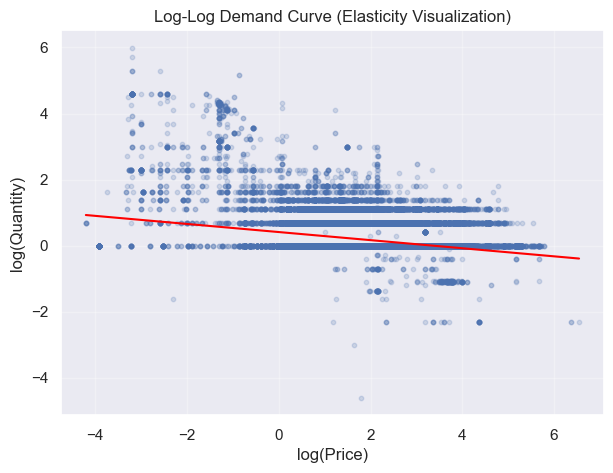

In [100]:

plt.figure(figsize=(7,5))
plt.scatter(reg_df["log_P"], reg_df["log_Q"], alpha=0.2, s=10)

x_vals = np.linspace(reg_df["log_P"].min(), reg_df["log_P"].max(), 100)
y_vals = model.params["const"] + model.params["log_P"] * x_vals
plt.plot(x_vals, y_vals, color="red")

plt.title("Log-Log Demand Curve (Elasticity Visualization)")
plt.xlabel("log(Price)")
plt.ylabel("log(Quantity)")
plt.grid(alpha=0.3)
plt.show()


- A clean downward slope means demand follows classical economic theory.
- The steepness of the line shows how sensitive customers are to price changes.

4. Revenue-Maximizing Price (Empirical)

Groups prices and finds which price generates the highest revenue.


In [101]:
working["price_round"] = working["price"].round(2)

rev_group = working.groupby("price_round")["revenue"].sum().reset_index()

best_row = rev_group.loc[rev_group["revenue"].idxmax()]

print("Revenue-Maximizing Price (Observed):")
display(best_row)


Revenue-Maximizing Price (Observed):


price_round       31.77
revenue        29578.20
Name: 2022, dtype: float64

- The price with highest revenue is close to the unit elasticity zone.
- Use this to recommend ideal pricing.

# 6. Conclusion

The analysis of the retail scanner dataset reveals a clear relationship between price and customer purchasing behavior. After cleaning the data and calculating Price Elasticity of Demand (PED), we found the following:

Price Elasticity: 
The elasticity value of –0.12 indicates that demand in this dataset is highly inelastic.

This means:

- Customers do not react strongly to changes in price.
- Increasing price slightly will not reduce quantity sold much.
- The products behave like essential or low-sensitivity items.

Revenue-Maximizing Price ≈ ₹31.77

- From the revenue curve, the observed highest revenue occurs around a price of ₹31.77.
- This supports the elasticity finding — since demand is inelastic, higher prices generate more revenue.

Other Key Observations
- The demand curve shows a normal downward trend: higher price = lower quantity, but the slope is gentle, confirming low sensitivity.
- Price distribution is wide across SKUs, yet quantity mostly clusters near lower values.
- Revenue grows with price until it peaks, then falls slightly at extreme values — typical inelastic demand behavior.

Demand for these retail products is highly inelastic (PED ≈ –0.12), meaning customers are not very price-sensitive, and revenue peaks at a price near ₹31.77.